# Day 16: ROC曲线和PR曲线



今天我们来仔细学习下基于混淆矩阵延伸出来的各类指标，帮助大家记忆，以及深入理解roc曲线和pr曲线。

#  一、前置代码

In [1]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('E:\study\PythonStudy\python60-days-challenge-master\data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("E:\study\PythonStudy\python60-days-challenge-master\data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集

In [2]:
from sklearn.ensemble import RandomForestClassifier #随机森林分类器
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 用于评估分类器性能的指标
from sklearn.metrics import classification_report, confusion_matrix #用于生成分类报告和混淆矩阵
import warnings #用于忽略警告信息
warnings.filterwarnings("ignore") # 忽略所有警告信息
# --- 1. 默认参数的随机森林 ---
# 评估基准模型，这里确实不需要验证集
print("--- 1. 默认参数随机森林 (训练集 -> 测试集) ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train) # 在训练集上训练
rf_pred = rf_model.predict(X_test) # 在测试集上预测


print("\n默认随机森林 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred))
print("默认随机森林 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred))

--- 1. 默认参数随机森林 (训练集 -> 测试集) ---

默认随机森林 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1059
           1       0.79      0.30      0.43       441

    accuracy                           0.77      1500
   macro avg       0.78      0.63      0.64      1500
weighted avg       0.77      0.77      0.73      1500

默认随机森林 在测试集上的混淆矩阵：
[[1023   36]
 [ 309  132]]


# 二、评估指标介绍

## 2.1 混淆矩阵含义介绍

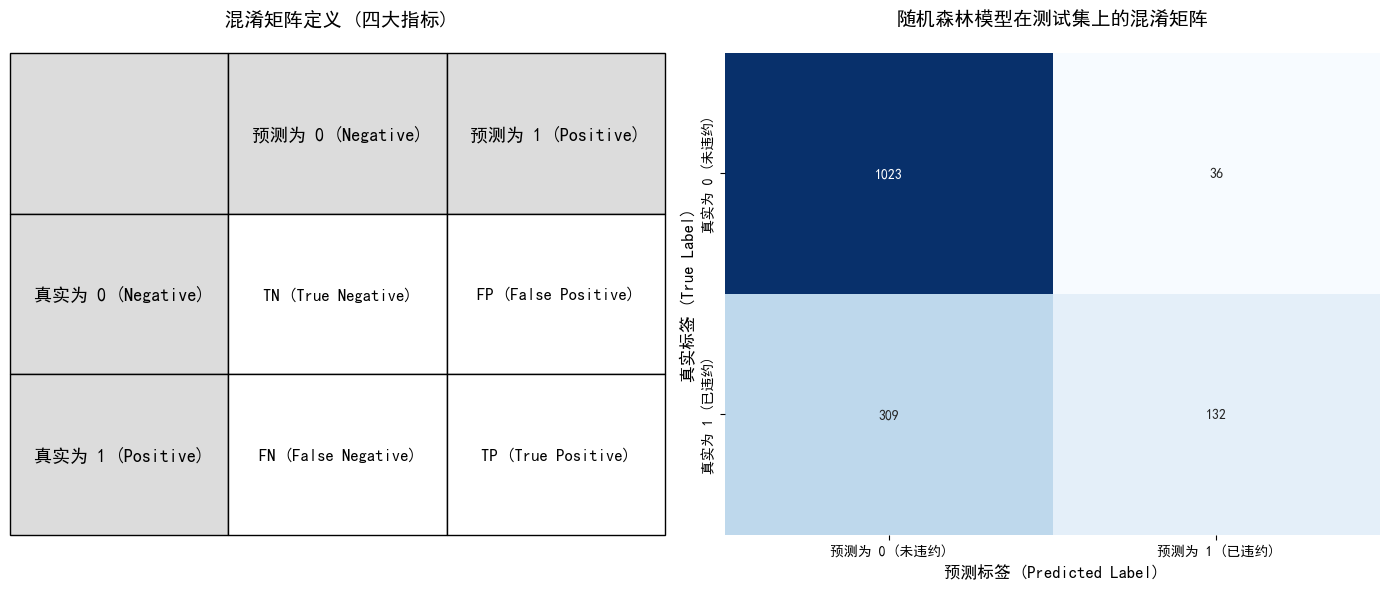

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设您已经运行了前面的代码并得到了 rf_pred
# cm = confusion_matrix(y_test, rf_pred)
cm = confusion_matrix(y_test, rf_pred) # 重新计算确保可用

# --- 设置子图布局 ---
# 创建一个包含 1 行 2 列的图表，figsize 略微放大以便容纳两个图
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
plt.rcParams['font.sans-serif'] = ['SimHei'] # 再次确保中文显示正常
plt.rcParams['axes.unicode_minus'] = False 

# --- 左侧子图 (axes[0]): 混淆矩阵定义表 ---
ax_table = axes[0]
ax_table.set_title('混淆矩阵定义 (四大指标)', fontsize=14, pad=20)
ax_table.axis('off') # 隐藏坐标轴，只显示表格内容

# 定义表格内容
table_data = [
    ['', '预测为 0 (Negative)', '预测为 1 (Positive)'],
    ['真实为 0 (Negative)', 'TN (True Negative)', 'FP (False Positive)'],
    ['真实为 1 (Positive)', 'FN (False Negative)', 'TP (True Positive)']
]

# 绘制表格
table = ax_table.table(
    cellText=table_data,
    loc='center', 
    cellLoc='center', # 文本居中
    bbox=[0, 0, 1, 1] # 表格填充整个子图空间
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2.5) # 调整表格大小以便更好地展示文字

# 设置第一行和第一列的背景色以突出标签
for i in range(len(table_data)):
    for j in range(len(table_data[0])):
        if i == 0 or j == 0:
            table[(i, j)].set_facecolor("#DCDCDC") # 浅灰色背景
            table[(i, j)].set_fontsize(13)
        table[(i, j)].set_edgecolor('black')


# --- 右侧子图 (axes[1]): 随机森林的混淆矩阵热力图 ---
ax_heatmap = axes[1]
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar=False,
            xticklabels=['预测为 0 (未违约)', '预测为 1 (已违约)'], 
            yticklabels=['真实为 0 (未违约)', '真实为 1 (已违约)'],
            ax=ax_heatmap) # 指定在右侧子图绘制

ax_heatmap.set_title('随机森林模型在测试集上的混淆矩阵', fontsize=14, pad=20)
ax_heatmap.set_ylabel('真实标签 (True Label)', fontsize=12)
ax_heatmap.set_xlabel('预测标签 (Predicted Label)', fontsize=12)

# 调整子图之间的间距
plt.tight_layout()
plt.show()

在二分类问题中，我们通常将我们更关注、希望模型能够成功识别的那个类别定义为正样本 (Positive)，而另一个类别则定义为负样本 (Negative)。

- 正样本,1,Positive (P),指的是信用违约的客户。这是我们最希望模型能够识别出来、避免损失的群体。
- 负样本,0,Negative (N),指的是信用未违约的客户。这是低风险、可以发放贷款的群体。


在风险管理中，识别出高风险（违约）客户比识别出低风险（未违约）客户具有更高的业务价值和紧迫性。---不要漏检
- FN (假阴性)：将违约客户错误地预测为未违约，会导致银行损失资金，后果严重。
- TP (真阳性)：成功预测违约，可以避免损失，价值高。


## 2.1 召回率 (Recall) / 真阳性率 (TPR)

召回率衡量的是模型抓住了多少真正的正样本。它关注的是所有真实的正样本中，被模型正确预测出来的比例。

$$Recall = TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$$



In [4]:
recall_score(y_test, rf_pred)

0.29931972789115646

## 2.2 假阳性率 (FPR)
FPR 衡量的是模型错误地将多少负样本判断为正样本。它是 ROC 曲线的横轴。

$$FPR = \frac{FP}{N} = \frac{FP}{FP + TN}$$

In [5]:
cm[0, 1] / (cm[0, 1] + cm[0, 0])

np.float64(0.0339943342776204)

## 2.3 精确率 (Precision)
精确率衡量的是模型预测的正样本有多准确。它关注的是所有被模型预测为正样本中，真正是正样本的比例。

$$Precision = \frac{TP}{TP + FP}$$

In [6]:
precision_score(y_test, rf_pred)

0.7857142857142857

## 2.4 准确率 (Accuracy)
准确率衡量的是模型整体的正确率。

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

In [7]:
accuracy_score(y_test, rf_pred)

0.77

## 2.5 F1 分数 (F1 Score)

F1 分数是精确率 (Precision) 和召回率 (Recall) 的调和平均值，旨在同时兼顾两者。当精确率和召回率都很高时，F1 分数才会高。

$$F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$$

In [8]:
f1_score(y_test, rf_pred)

0.43349753694581283

# 三、ROC 曲线 (Receiver Operating Characteristic Curve)

ROC 曲线是评估二分类模型性能的标准工具之一，它描绘了模型在各种分类阈值下，捕捉正样本的能力 (TPR) 与错误识别负样本的能力 (FPR) 之间的权衡。

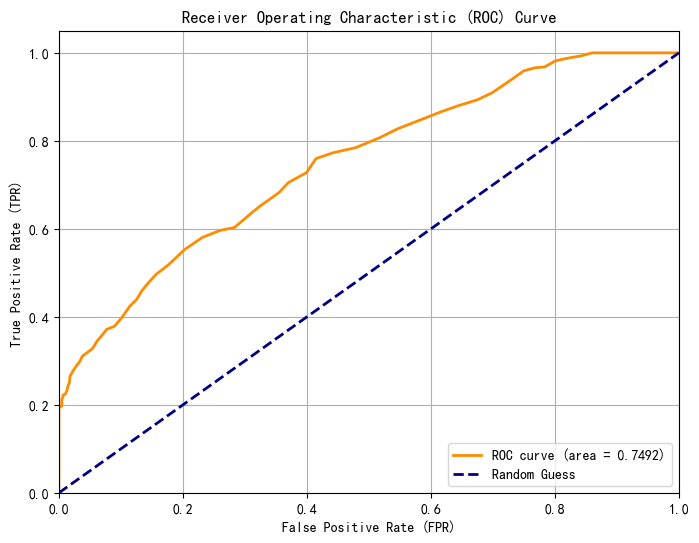


模型在测试集上的 AUC (Area Under the Curve): 0.7492


In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 预测测试集上的概率（注意：ROC曲线需要的是预测概率，而不是最终的类别预测）
# predict_proba() 返回一个 n_samples x n_classes 的数组，我们需要正类（1）的概率，即第二列
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 1. 计算 ROC 曲线的 FPR 和 TPR
# y_test 是真实标签，rf_pred_proba 是正类的预测概率
fpr, tpr, thresholds = roc_curve(y_test, rf_pred_proba)

# 2. 计算 AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# 3. 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess') # 对角线
plt.xlim([0.0, 1.0]) # 设置 x 轴范围
plt.ylim([0.0, 1.05]) # 设置 y 轴范围，稍微超出 1.0
plt.xlabel('False Positive Rate (FPR)') # x 轴标签
plt.ylabel('True Positive Rate (TPR)') # y 轴标签
plt.title('Receiver Operating Characteristic (ROC) Curve') # 图表标题
plt.legend(loc="lower right") # 图例位置
plt.grid(True) # 显示网格
plt.show()

print("\n模型在测试集上的 AUC (Area Under the Curve): %0.4f" % roc_auc)

ROC 曲线是以假正率 (False Positive Rate, FPR) 为横坐标，真正率 (True Positive Rate, TPR) 为纵坐标绘制的曲线。真正率 (TPR) / 召回率 (Recall)：$$TPR = \frac{TP}{TP + FN}$$解读：所有实际为正例的样本中，被模型正确识别出来的比例。（越高越好）假正率 (FPR)：$$FPR = \frac{FP}{FP + TN}$$解读：所有实际为负例的样本中，被模型错误识别为正例的比例。（越低越好）ROC 曲线通过在不同的分类阈值下计算 TPR 和 FPR，并将这些点连接起来而形成。


- 曲线越靠近左上角:模型性能越好。这意味着在获得高 TPR（多识别出正例）的同时，能保持低 FPR（少将负例错判为正例）。
- 对角线（$y=x$）:代表模型的性能与随机猜测相同（AUC=0.5）。
- 曲线在对角线下方:模型性能比随机猜测还差，通常意味着模型对正负样本的预测是相反的（预测概率需要反转）。

AUC 表示模型将随机选择的一个正样本排在随机选择的一个负样本之前的概率。 例如，如果 AUC=0.85，意味着随机抽取一个正例和一个负例，模型有 85% 的概率认为这个正例的得分（预测概率）高于那个负例的得分。


对样本不均衡不敏感： ROC 曲线的两个指标（TPR 和 FPR）都是分别基于正样本和负样本独立计算的。因此，即使数据集中正负样本比例严重不平衡，ROC 曲线的形状和 AUC 值也不会像准确率 (Accuracy) 那样受到很大的影响。这使得 AUC 成为评估不均衡数据集模型的首选指标。

衡量模型泛化能力： 它能评估模型在所有可能的分类阈值下对样本的排序能力。

简而言之，当您需要衡量一个模型区分正负样本的能力，尤其是在数据不平衡的情况下，AUC 是一个比简单准确率更可靠的指标。

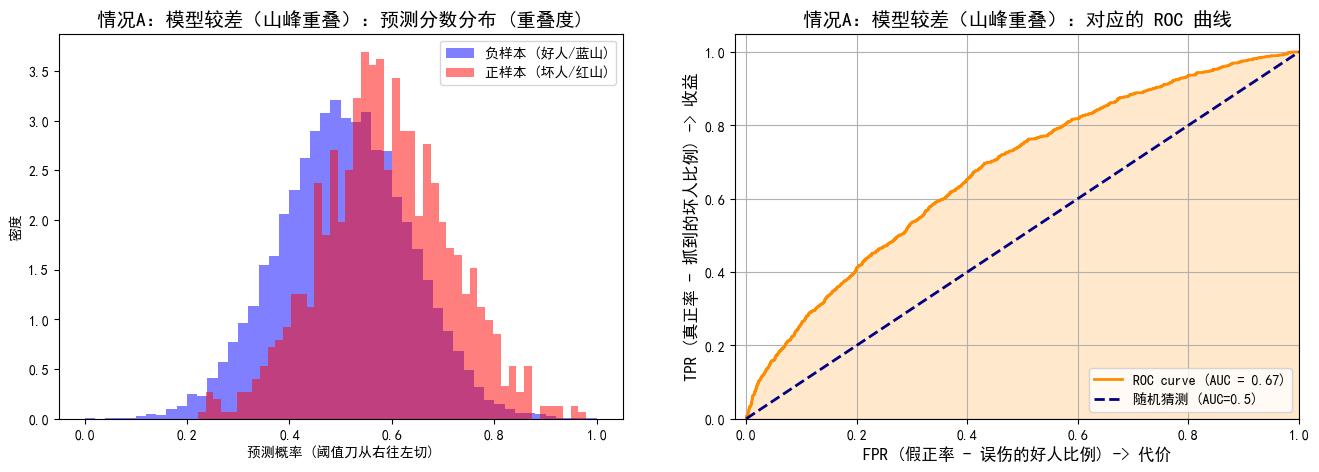

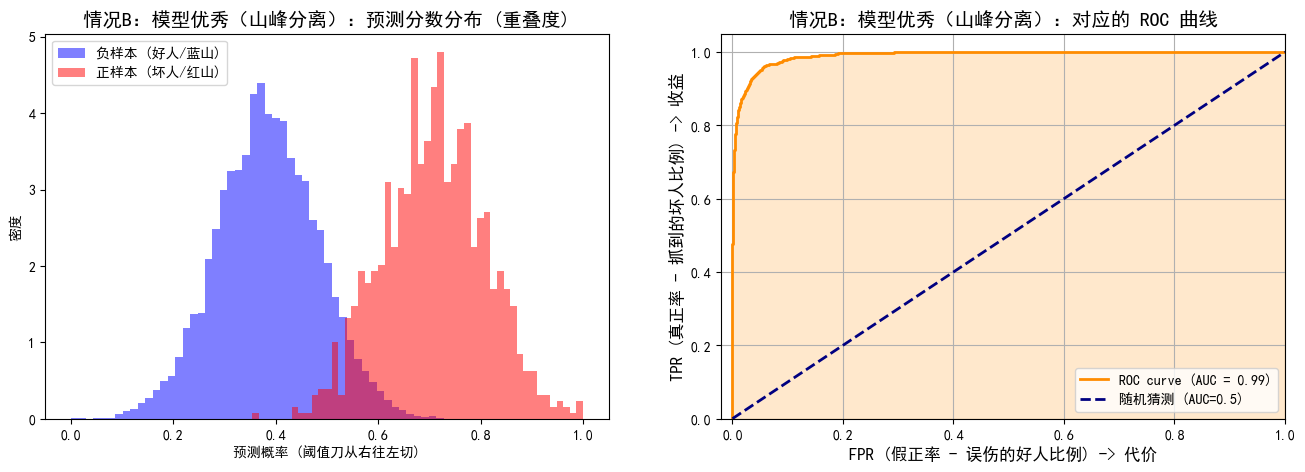

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

def plot_distribution_and_roc(mu_neg, mu_pos, title_prefix):
    # --- 1. 模拟数据 (完全沿用之前的逻辑) ---
    # 负样本分布 (好人，分数低)
    n_neg = 10000
    neg_scores = np.random.normal(loc=mu_neg, scale=0.15, size=n_neg)
    
    # 正样本分布 (坏人，分数高)
    n_pos = 1000 
    pos_scores = np.random.normal(loc=mu_pos, scale=0.15, size=n_pos)

    # 合并
    y_true = np.array([0] * n_neg + [1] * n_pos)
    y_scores = np.concatenate([neg_scores, pos_scores])
    
    # 归一化
    y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    # --- 2. 计算 ROC 曲线的关键差异点 ---
    # 这里的输入和 PR 曲线一模一样，但输出变成了 FPR 和 TPR
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # --- 绘图 ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # === 左图：分布图 (保持不变) ===
    ax1.hist(y_scores[y_true==0], bins=50, alpha=0.5, color='blue', label='负样本 (好人/蓝山)', density=True)
    ax1.hist(y_scores[y_true==1], bins=50, alpha=0.5, color='red', label='正样本 (坏人/红山)', density=True)
    ax1.set_title(f'{title_prefix}：预测分数分布 (重叠度)', fontsize=14)
    ax1.set_xlabel('预测概率 (阈值刀从右往左切)')
    ax1.set_ylabel('密度')
    ax1.legend()

    # === 右图：ROC 曲线 (核心变化) ===
    # 绘制 ROC 曲线
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    
    # 绘制对角线 (随机猜测基准线)
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机猜测 (AUC=0.5)')
    
    # 填充曲线下面积
    ax2.fill_between(fpr, tpr, color='darkorange', alpha=0.2)

    ax2.set_title(f'{title_prefix}：对应的 ROC 曲线', fontsize=14)
    ax2.set_xlabel('FPR (假正率 - 误伤的好人比例) -> 代价', fontsize=12)
    ax2.set_ylabel('TPR (真正率 - 抓到的坏人比例) -> 收益', fontsize=12)
    ax2.set_xlim([-0.02, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.legend(loc="lower right")
    ax2.grid(True)

    plt.show()

# --- 运行对比 ---

# 情况一：模型很差 (山峰严重重叠)
# 逻辑：你想抓红球，必然会抓到一大把蓝球。
plot_distribution_and_roc(mu_neg=0.4, mu_pos=0.5, title_prefix="情况A：模型较差（山峰重叠）")

# 情况二：模型很好 (山峰分得很开)
# 逻辑：你可以先把红球抓干净，都还碰不到蓝球。
plot_distribution_and_roc(mu_neg=0.3, mu_pos=0.8, title_prefix="情况B：模型优秀（山峰分离）")

# 四、PR曲线

PR 曲线 (Precision-Recall Curve)关注的是模型在不同分类阈值下，精确率 (Precision) 和 召回率 (Recall) 之间的权衡关系。

横轴 (X 轴)：召回率 (Recall) (即 TPR，真阳性率)。$$Recall = \frac{TP}{TP + FN}$$纵轴 (Y 轴)：精确率 (Precision)。$$Precision = \frac{TP}{TP + FP}$$

PR 曲线的每个点对应一个分类阈值。当阈值降低时，模型倾向于将更多样本预测为正类 (1)，召回率通常会增加，但精确率可能会下降，因为模型可能会引入更多的假阳性 (FP)。

PR 曲线通过改变分类模型的阈值，将不同阈值下的 (Recall, Precision) 点连接起来。

曲线越靠近右上角（即曲线下的面积越大），模型的性能越好。

PR 曲线的终点通常是从左下角 (0, P_total) 附近开始，逐渐向右上角延伸。


与 ROC 曲线的 AUC 类似，PR 曲线下的面积称为 AUPRC (Area Under the Precision-Recall Curve) 或 平均精确率 (Average Precision, AP)。

AP 值越高，模型在高召回率的情况下也能保持较高的精确率，这通常意味着更好的性能。

在高度不平衡的数据集上，即使 ROC-AUC 值很高（因为它只受到负样本数量的影响），PR-AP 值也可能很低，PR-AP 能更真实地反映模型在少数类上的表现。

当前处理的信用违约（Credit Default）预测问题中，如果违约样本（正例）远少于正常样本（负例），PR 曲线和 AUPRC 是比 ROC-AUC 更加重要的评估指标，因为它直接反映了您找到真正违约用户（高 Recall）同时不误伤太多正常用户（高 Precision）的能力。

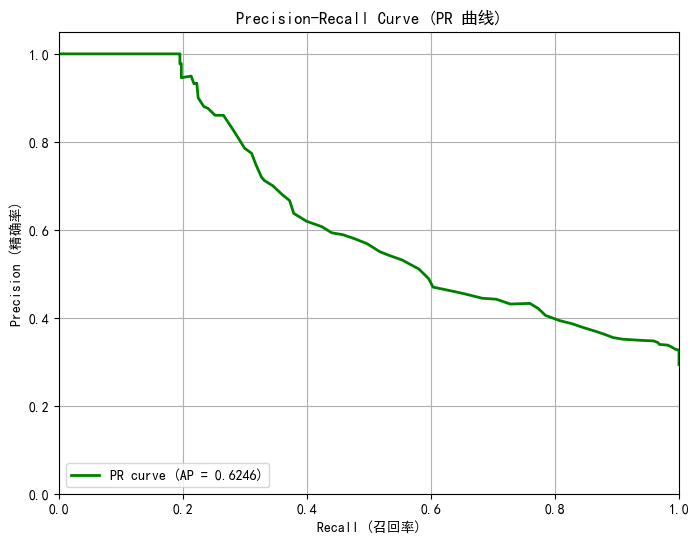


模型在测试集上的 AP (Average Precision): 0.6246


In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 预测测试集上的概率（与ROC曲线使用相同的概率）
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 1. 计算 PR 曲线的 Precision 和 Recall
precision, recall, _ = precision_recall_curve(y_test, rf_pred_proba)

# 2. 计算 AP (Average Precision)
average_precision = average_precision_score(y_test, rf_pred_proba)

# 3. 绘制 PR 曲线
plt.figure(figsize=(8, 6))
# 绘制 PR 曲线
plt.plot(recall, precision, color='green', lw=2, 
         label='PR curve (AP = %0.4f)' % average_precision)

# 设置轴标签和标题
plt.xlabel('Recall (召回率)')
plt.ylabel('Precision (精确率)')
plt.title('Precision-Recall Curve (PR 曲线)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print("\n模型在测试集上的 AP (Average Precision): %0.4f" % average_precision)

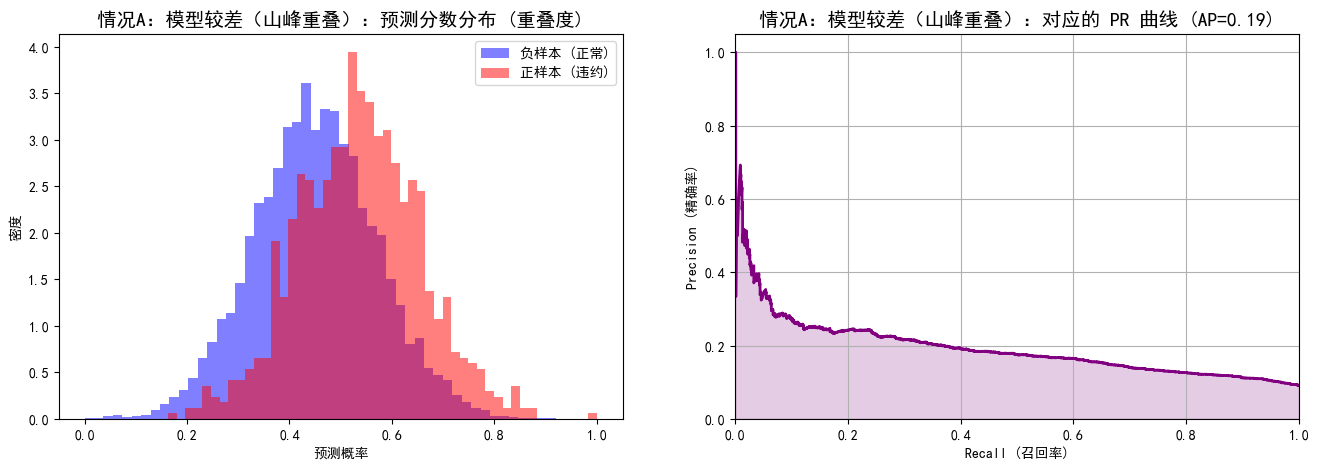

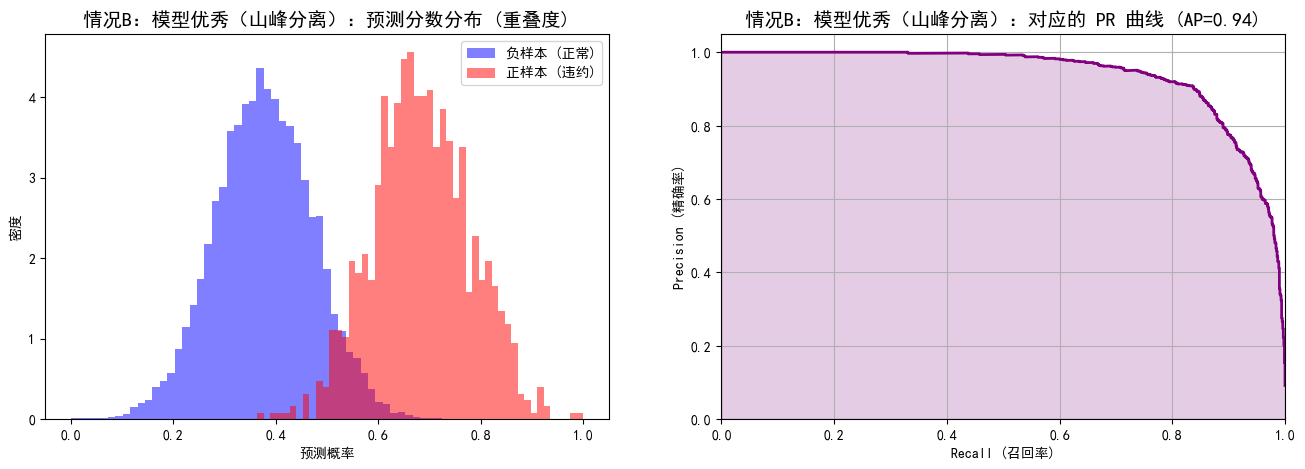

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_distribution_and_pr(mu_neg, mu_pos, title_prefix):
    # 1. 模拟数据：生成正负样本的预测得分
    # 负样本分布 (大多数人是好人，分数低)
    n_neg = 10000
    neg_scores = np.random.normal(loc=mu_neg, scale=0.15, size=n_neg)
    
    # 正样本分布 (少数人是坏人，分数高)
    n_pos = 1000 
    pos_scores = np.random.normal(loc=mu_pos, scale=0.15, size=n_pos) # loc决定了山峰分开的程度

    # 合并标签和分数
    y_true = np.array([0] * n_neg + [1] * n_pos)
    y_scores = np.concatenate([neg_scores, pos_scores])
    
    # 将分数归一化到 0-1 之间 (模拟概率)
    y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    # 2. 计算 PR 曲线
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    # --- 绘图 ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # 左图：正负样本分布 (您记忆中的“两个图像”)
    ax1.hist(y_scores[y_true==0], bins=50, alpha=0.5, color='blue', label='负样本 (正常)', density=True)
    ax1.hist(y_scores[y_true==1], bins=50, alpha=0.5, color='red', label='正样本 (违约)', density=True)
    ax1.set_title(f'{title_prefix}：预测分数分布 (重叠度)', fontsize=14)
    ax1.set_xlabel('预测概率')
    ax1.set_ylabel('密度')
    ax1.legend()

    # 右图：PR 曲线
    ax2.plot(recall, precision, color='purple', lw=2)
    ax2.fill_between(recall, precision, color='purple', alpha=0.2)
    ax2.set_title(f'{title_prefix}：对应的 PR 曲线 (AP={ap:.2f})', fontsize=14)
    ax2.set_xlabel('Recall (召回率)')
    ax2.set_ylabel('Precision (精确率)')
    ax2.set_ylim([0, 1.05])
    ax2.set_xlim([0, 1.0])
    ax2.grid(True)

    plt.show()

# 运行模拟

# 情况一：模型分得不开 (严重重叠) -> PR 曲线下面积很小
plot_distribution_and_pr(mu_neg=0.4, mu_pos=0.5, title_prefix="情况A：模型较差（山峰重叠）")

# 情况二：模型分得很开 (分离良好) -> PR 曲线下面积很大
plot_distribution_and_pr(mu_neg=0.3, mu_pos=0.8, title_prefix="情况B：模型优秀（山峰分离）")